In [ ]:
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn


import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

!gdown 1GUI8x3Hxze1nqb1-Ban-tDtdfyLSSAhM

Downloading...
From: https://drive.google.com/uc?id=1GUI8x3Hxze1nqb1-Ban-tDtdfyLSSAhM
To: /content/Img_file.zip
100% 15.2M/15.2M [00:00<00:00, 86.7MB/s]


In [ ]:
TRAIN = False #the training flag

# **Model Card**

**Input:**
Image of a human face

**Output Categories:**

Anger, Contempt, Disgust, Fear, Happy, Neutral, Sad, Surprise

**Training Dataset:**

800 images of human faces categorized into 8 emotion classes (100 images per class), with source: https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis

**Intended Use:**

The model can be utilized in various applications such as:
Market Research: Analyzing consumer responses to products or advertisements.

Customer Service: Assessing customer sentiment during interactions.

Healthcare: Monitoring patient emotional states for mental health assessment.



**Risks:**

Ambiguity in Emotion Categories:Facial expression may signify a mix of multiple emotions instead of a single one. Such a tendency is stronger, for example, in the Asian population.

Demographic Disparities:
 While the link between facial expression and emotion is rather universal, the model's performance may vary across different demographic groups, because the training data is not adequately representative of the population diversity.
Individuals from collectivists culture, for example, tend to hide facial expression of emotion.

source: Aronson, E., Wilson, T. D., Akert, R. M., & Sommers, S. R. (2018). Social psychology (10th ed.).


# **Introduction**

Our project aims to compare the performance of two classes of neural networks - a fully connected neural network and a convolutional neural network - in recognizing and classifying human emotions from images in terms of prediction accuracy, loss, time to convergence, etc. Accurate emotion classification can enhance numerous real-world applications, such as advancing psychological and clinical research, supporting social justice initiatives, fostering child development, and more. Additionally, we seek to investigate the impact of regularization on generalization, aiming to discern whether excessively high regularization parameters, lambda, could hinder learning processes. The input to our problem is a dataset consisting of 800 human emotion images with 8 distinct labels, ranging from "anger" to "sad". The output is the classification of the image into one of the eight predefined emotion classes. We use a Fully Connected Neural Network and a Convolutional Neural Network.


# **Method**

We train variants of two different models described in class, a fully connected neural network (FCNN) and a convolutional neural network (CNN), on a dataset with 800 samples. Each sample is an image of a human face expressing one of the following emotions: anger, contempt, disgust, fear, happiness, neutrality, sadness, and surprise. We use PyTorch for implementation.


In [ ]:
#import training set
FILE_PATH = '/content/extracted_files'
with zipfile.ZipFile('/content/Img_file.zip', 'r') as ref:
  ref.extractall(FILE_PATH)
Categories = [os.listdir("/content/extracted_files/Img_file/" + str(i)) for i in range(8)]


**Preprocess:**

We use the normalization method presented in HW7, to reduce the inherent noise and fix the input size. We randomly split the dataset into a training set of 640 samples and a testing set of 160 samples. To prevent overrepresentation of a particular category in the training set, we randomly assign 80 samples from each classes to the training set.


In [ ]:
#create training and testing set
from sklearn.model_selection import train_test_split
S = []
for i in range(len(Categories)):
  for f in Categories[i]:
    path = os.path.join("/content/extracted_files/Img_file/"+str(i),f)
    S.append((path,i))
X = [each[0] for each in S]
y = [each[1] for each in S]


train_X = []
test_X = []
train_y =[]
test_y = []

for i in range(8):
  X_cati = []
  y_cati = []
  for j in range(len(X)):
    if y[j] == i:
      X_cati.append(X[j])
      y_cati.append(y[j])
  train_X_cati,test_X_cati,train_y_cati,test_y_cati = train_test_split(X_cati,y_cati,test_size = 0.2,random_state = 114514)
  train_X += train_X_cati
  test_X += test_X_cati
  train_y += train_y_cati
  test_y +=test_y_cati




**Sample display**

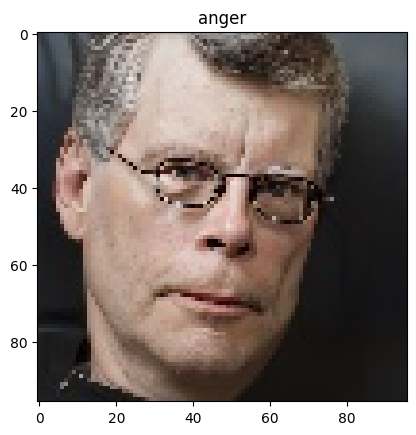

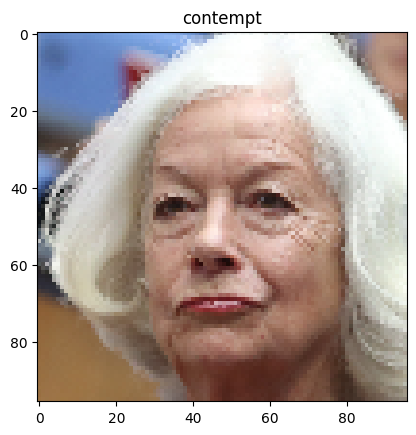

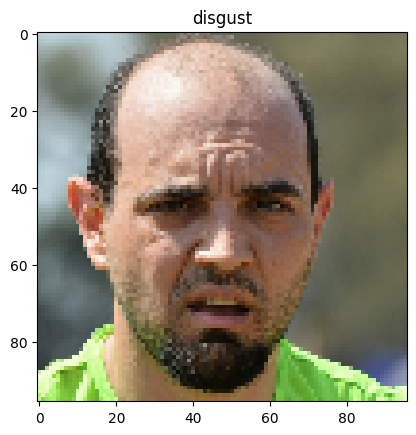

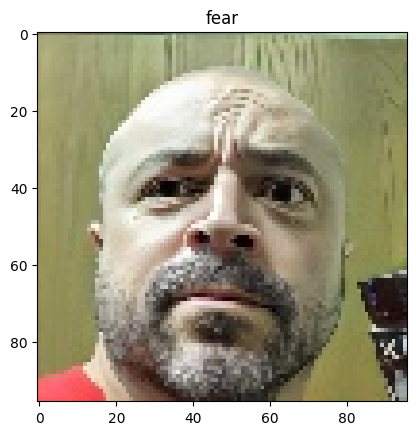

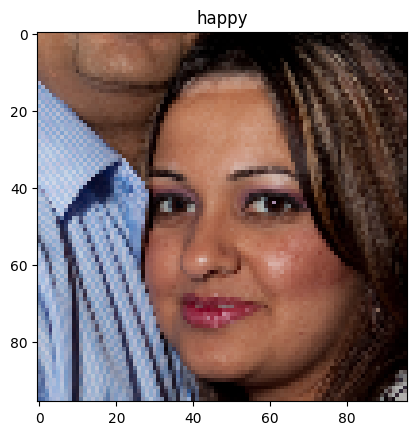

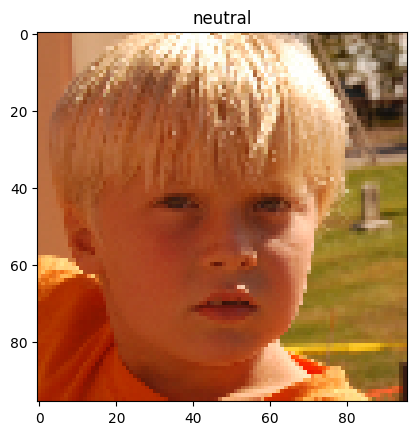

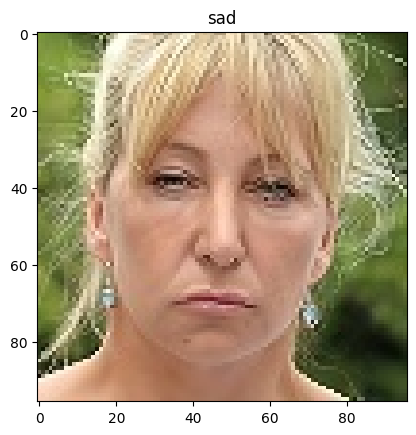

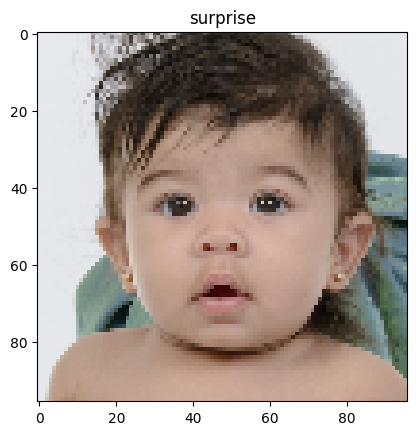

In [ ]:
#sample display
CLASSNAME_8_LABEL = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 5: "neutral", 6: "sad", 7: "surprise"}

for i in range(len(Categories)):
  for f in Categories[i]:
    path = os.path.join("/content/extracted_files/Img_file/"+str(i),f)
    image = Image.open(path)
    label = CLASSNAME_8_LABEL[i]
    plt.title(label, fontsize=12)
    plt.imshow(image)
    plt.show()
    break



In [ ]:
SIZE = 224 #dataset code
class emotionDmgDataset(Dataset):
  def __init__(self,split,size = SIZE):
     #super().__init__()
     self.size = size
     self.split = split

  def __len__(self):
    return int(0.2 * 800) if self.split == 'test' else int(0.8 * 800)

  def __getitem__(self,idx):
    if self.split == "train":
      img_path = train_X[idx]
      label = train_y[idx]
    else:
      img_path = test_X[idx]
      label = test_y[idx]
    img = Image.open(img_path)

    allTransforms = transforms.Compose([
            transforms.Resize(size  = (self.size, self.size)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    img = allTransforms(img)
    img = torch.FloatTensor(img)
    return img, label

**Sample display(after transformation)**

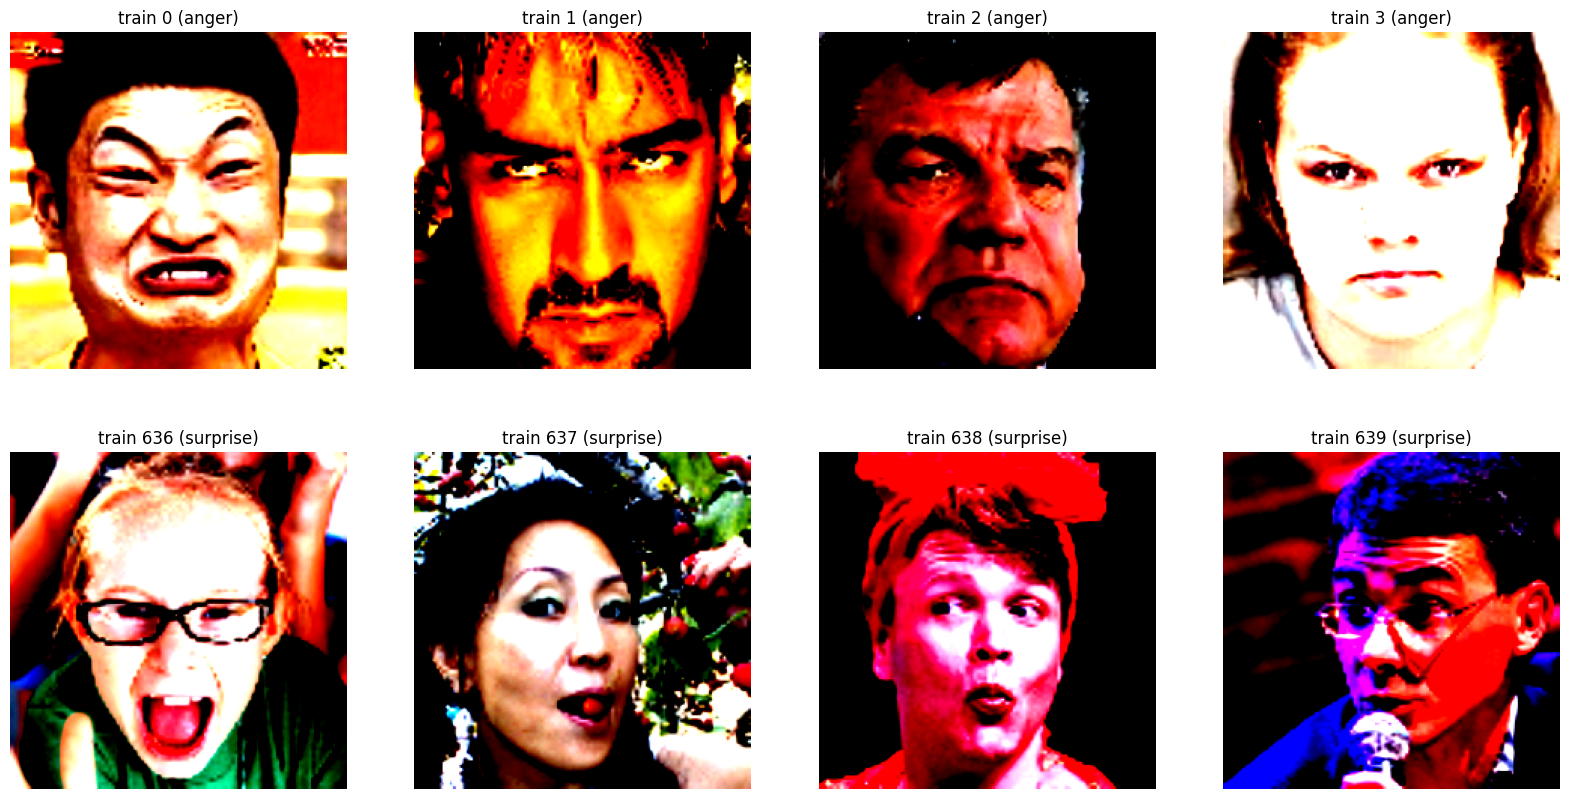

In [ ]:
train_dataset = emotionDmgDataset(split = "train")
test_dataset = emotionDmgDataset(split = "test")

indices = list(range(4)) + list(range(len(train_dataset)-4, len(train_dataset)))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes_flat = axes.flatten()

for i, id in enumerate(indices):

    (image, label) = train_dataset[id]
    image = torch.clip(image, min = 0, max = 1)
    image = image.permute(1, 2, 0)

    label_str = CLASSNAME_8_LABEL[label]
    axes_flat[i].imshow(image)
    axes_flat[i].set_title(f'train {id} ({label_str})')
    axes_flat[i].axis('off')


plt.show()




**CNN:**

We finetune ResNet18 as our CNN. To make it fit our task, the last fully connected layer is changed to output 8 categories instead of 1000 as in the original model. To investigate the effect of regularization, we train another variant of ResNet18 with a dropout layer.


In [ ]:

class CNN(nn.Module):
    def __init__(self, pretrained=False, dropout = False, dropout_p = 0.3):
        super(CNN, self).__init__()

        facenet = torchvision.models.resnet18(pretrained=pretrained)
        if not dropout:
          facenet.fc = nn.Linear(in_features=512, out_features=8, bias=True)
        else:
            facenet.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features=512, out_features=8, bias=True)
        ) #credit: https://discuss.pytorch.org/t/adding-dropout-layer-in-pretrained-resnet3d/85697


        self.facenet = facenet
        self.finalActivation = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.facenet(x)
        y_hat = self.finalActivation(x)
        return y_hat

In [ ]:

def one_hot_h(x):
    res = np.zeros(8)
    res[x] = 1
    return res

def one_hot(y):
    res = []
    for i in range(len(y)):
      res.append(one_hot_h(y[i]))
    return torch.tensor(res, dtype = float)

**FCNN:**

Our FCNN network involves two fully connected layers and a softmax layer. After the first fully connected layer is a ReLU activation function. The input to our FCNN network is each image flattened down to a 1D array.


In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features = SIZE * SIZE * 3, out_features = SIZE * 3, bias = True)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = SIZE * 3, out_features = 8, bias = True)
        self.activation2 = nn.Softmax(dim = 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        y_hat = self.activation2(x)
        return y_hat

**Training and utility functions:**

The training and its related utility functions are copied from HW7, with a minor change to accommodate our multi-class classification. For all models, we use a learning rate of 0.001 along with momentum descent to ensure relatively fast convergence and to avoid getting stuck in local minima. We set our batch size to 16 to mitigate overfitting, acknowledging the fact that we have limited training examples. We train each network for 30 epoches except for CNN with a high dropout, as it takes longer for this network to converge.


In [ ]:
def evalDL(model, dl, lossfn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for x, y in dl:
            y = one_hot(y)
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            #print("yhat is",yhat,yhat.shape)
            #print("y is",y,y.shape)
            lossSum += lossfn(yhat, y) * x.shape[0]
            for i in range(len(y)):
              pred = yhat[i]
              val = y[i]
              if torch.argmax(pred) == torch.argmax(val):
                nCorrect += 1
        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(),acc

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evalDL(model, trainDL, lossfn)
    validLoss, validAcc = evalDL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

In [ ]:

def train(model, trainDL, validDL, lossfn, opt, epochs=10):
    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)
    print(f"Initial Model: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")
    model.to(device)

    for e in range(epochs):
        for X, y in trainDL:

            y = one_hot(y)

            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            y_hat = model.forward(X)

            loss = lossfn(y_hat, y)
            loss.backward()
            opt.step()
        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)
        print(f"Epoch {e:>4d}: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")
    return model, trainLosses, trainAccs, validLosses, validAccs

In [ ]:
def plotStatistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    fig.subplots_adjust(wspace=0.4)
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.grid()
    axis.legend()

    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.grid()
    axis.legend()

In [ ]:
# [AG] defining the datasets, data-loaders, loss functions, and optimizers
def createTrainingUtils(model,batch_size,lr,l2W = 0):
    trainDL, testDL, lossfn, opt = None, None, None, None

    trainDL = DataLoader(emotionDmgDataset("train"), batch_size = batch_size, shuffle = True)
    testDL = DataLoader(emotionDmgDataset("test"), batch_size = batch_size, shuffle = True)
    lossfn = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr = lr,momentum = 0.9,weight_decay = l2W)

    return trainDL, testDL, lossfn, opt

In [ ]:
from google.colab import files
#saving file credit: https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models
#saving weight credit: https://discuss.pytorch.org/t/how-to-save-model-weights-to-local-machine-from-colab/33318/2

def trainAndPlot():
    model = CNN(pretrained = True)
    trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, validDL, lossfn, opt, epochs=40)
    plotStatistics(40, trainLosses, trainAccs, validLosses, validAccs)

    return model



def trainAndPlotAndSave(model,batch_size = 16, lr = 0.001, l2W = 0.01, epoch = 30, file_name = "sample", download = False):
  #the function for training & saving weight
    if not TRAIN:
      return
    model = model
    trainDL, validDL, lossfn, opt = createTrainingUtils(model,batch_size,lr,l2W)
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, validDL, lossfn, opt, epochs=epoch)
    plotStatistics(epoch, trainLosses, trainAccs, validLosses, validAccs)

    save_dict = {
        'trainLosses': trainLosses,
        'trainAccs': trainAccs,
        'validLosses':validLosses,
        'validAccs':validAccs
    }
    if download:
      file_log_name = file_name + "_log.pt"
      file_name = file_name +".pt"
      torch.save(save_dict,file_log_name)
      torch.save(model.state_dict(), file_name )
      files.download(file_name)
      files.download(file_log_name)






# **Result and Discussion**

We first want to compare the learning capacity of the two models for our specific task. We show that the specific modeling assumption of the CNN helps it learn the task with greater precision and efficiency than the traditional FCNN.

In logistic regression and fully connected networks approximating it (like our FCNN), there is a common modeling assumption that the input parameters are independently and identically distributed. However, this assumption is not generally true in an image classification task, where the color of a pixel is strongly related to that of its surroundings. Therefore, the nature of the FCNN models makes the network hard to grasp the intrinsic pattern of each input that finally maps it to a certain output. As can be shown in the plot below, the network converges to a local minima about 15 epochs into training , and generalizes poorly to the validation set. Accuracy was (95%,30%) for training and validation.


In [ ]:
!gdown 1XB0DrDB7Zcj8joyRYL9HuyekGIyNULLv

Downloading...
From (original): https://drive.google.com/uc?id=1XB0DrDB7Zcj8joyRYL9HuyekGIyNULLv
From (redirected): https://drive.google.com/uc?id=1XB0DrDB7Zcj8joyRYL9HuyekGIyNULLv&confirm=t&uuid=911579b0-40b3-406b-9540-786edb1bb3a9
To: /content/weights_and_logs.zip
100% 208M/208M [00:01<00:00, 144MB/s]


In [ ]:


FILE_PATH = '/content'

with zipfile.ZipFile('/content/weights_and_logs.zip', 'r') as ref:
  ref.extractall(FILE_PATH)

def plot_sample(sample_name,epoch = 30):
    if TRAIN == True:
      return
    file_name = sample_name + ".pt"
    file_log_name = sample_name + "_log.pt"
    loaded_dict = torch.load("/content/" + file_log_name)
    trainLosses = loaded_dict['trainLosses']
    trainAccs = loaded_dict['trainAccs']
    validLosses = loaded_dict['validLosses']
    validAccs = loaded_dict['validAccs']
    model_weight = None
    if sample_name != "FCNN_control":
      model_weight = torch.load("/content/" +  file_name)
    plotStatistics(epoch, trainLosses, trainAccs, validLosses, validAccs)
    return model_weight


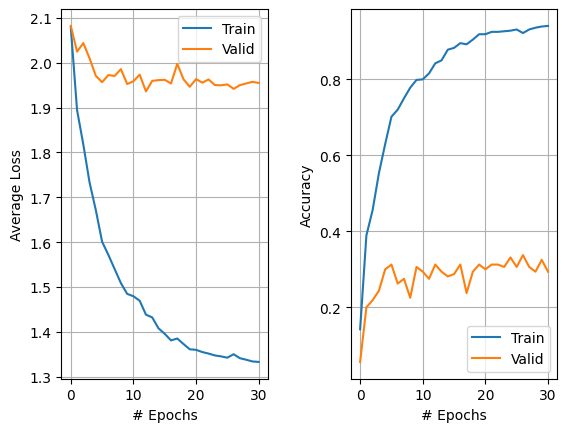

In [ ]:
###for training mode
fcnn_model = FCNN()
trainAndPlotAndSave(fcnn_model,batch_size = 16, lr = 0.001, epoch =30, l2W = 0, file_name = "FCNN_control",download = False)
###for testing mode
w = plot_sample("FCNN_control")





In contrast, the CNN typically assumes that input parameters are dependent on each other, as indicated in the use of filtering and pooling layers. The use of kernels and pooling ensures that at each layer, the collective activation of a particular group of adjacent neurons is what finally contributes to the activation of a neuron in the next layer. This allows the networks to capture lower-level to higher-level features encoded by groups of adjacent pixels and neurons. Moreover, kernels maintain a property of equivariance, where the spatial shift of a feature does not impact its final perception by the network. This is an important aspect for our image classification, as facial features do not appear in fixed places in images.

As shown in the learning plot below, our CNN can learn the training set with 97% classification accuracy after about 30 epochs of training, and get a 41% accuracy on the validation set . This shows how the modeling assumption of CNN helps it learn the dataset more nicely.


Initial Model: train-loss=1.36 train-acc=0.97 valid-loss=1.87 valid-acc=0.42
Epoch    0: train-loss=1.36 train-acc=0.98 valid-loss=1.86 valid-acc=0.42


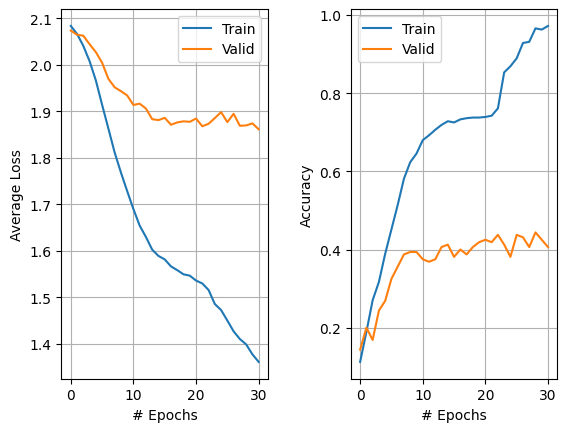

In [ ]:
###for training mode
cnn_control = CNN(pretrained = True, dropout = False, dropout_p = 0.5)
trainAndPlotAndSave(cnn_control,batch_size = 16, lr = 0.001, epoch =30, l2W = 0, file_name = "CNN_control",download = False)
###for testing mode
weight = plot_sample("CNN_control")
if not TRAIN:
  model = cnn_control
  model.load_state_dict(weight)
  trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
  train(model, trainDL, validDL, lossfn, opt, epochs=1)

We further note that the training time and storage space is more significant for our FCNN than CNN: FCNN has 101160872 parameters, while CNN only has  1180616 parameters, so FCNN is about 10 times larger than CNN. This is due to the weight sharing of kernels at convolution layers greatly reducing the number of weight use.

In [ ]:
model = FCNN()
print("# of params for FCNN is",sum(p.numel() for p in model.parameters()))
model = CNN(pretrained = True, dropout = False, dropout_p = 0.5)
print("# of params for CNN is",sum(p.numel() for p in model.parameters()))

# of params for FCNN is 101160872
# of params for CNN is 11180616


Next, we note that our CNN generalizes poorly on the validation set. We want to experiment with two techniques to improve the generalization performance. We first note that our dataset warrants prevention against underfitting: we have only 80 samples per category in the training set, a fairly small dataset. We employ two regularization techniques to prevent overfitting, the first being traditional L2 regularization, and the second being the addition of a dropout layer at the last fully connected layer.
We also wish to study under what conditions will these regularization techniques impede our network from learning the task, so we choose some hyper-parameters that are high.

We experimented with two lambda values for regularization: 0.001, and 0.25. When the lambda is set to 0.001, we observe a little improvement of this model from the model trained without regularization, as shown below. We have accuray = (98%,47%) for training and validation set. This observation can be attributed to the fact that even a small lambda could help the model to penalize against large weights. However, the improvement is rather non-significnat, probably because our dataset is indeed too small.

Initial Model: train-loss=1.31 train-acc=0.98 valid-loss=1.82 valid-acc=0.49
Epoch    0: train-loss=1.31 train-acc=0.98 valid-loss=1.83 valid-acc=0.46


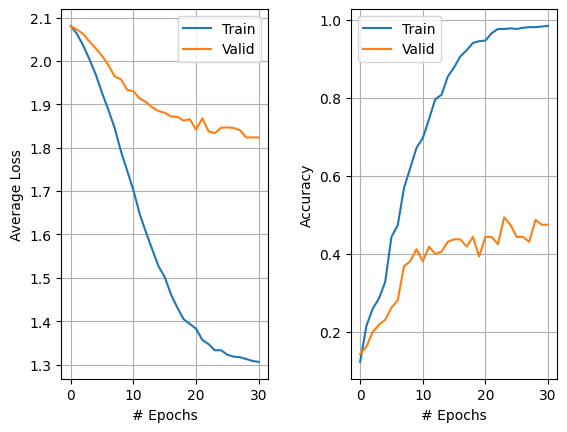

In [ ]:
###for training mode
cnn_low_decay = CNN(pretrained = True, dropout = False, dropout_p = 0.0)
trainAndPlotAndSave(cnn_low_decay,batch_size = 16, lr = 0.001, epoch =30, l2W = 0.001, file_name = "CNN_low_decay",download = False)
###for testing mode
weight = plot_sample("CNN_low_decay")
if not TRAIN:
  model = cnn_low_decay
  model.load_state_dict(weight)
  trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
  train(model, trainDL, validDL, lossfn, opt, epochs=1)



When lambda = 0.25, we can see that the penalty is too high for the model to learn effectively. The lambda term in the loss function prevents the model from assigning reasonable weights to each neuron, causing underfitting to the training examples.

Interestingly, we observe that as we overtrain the model, the weight decay terms exerts a stronger influence on the model. The effect of over-regularization drives the weight down to 0, making it hard to convey meaningful gradient after about 15 epoches of training, causing the performance of the network to even degrade.

Initial Model: train-loss=2.05 train-acc=0.35 valid-loss=2.06 valid-acc=0.27
Epoch    0: train-loss=2.04 train-acc=0.35 valid-loss=2.05 valid-acc=0.27


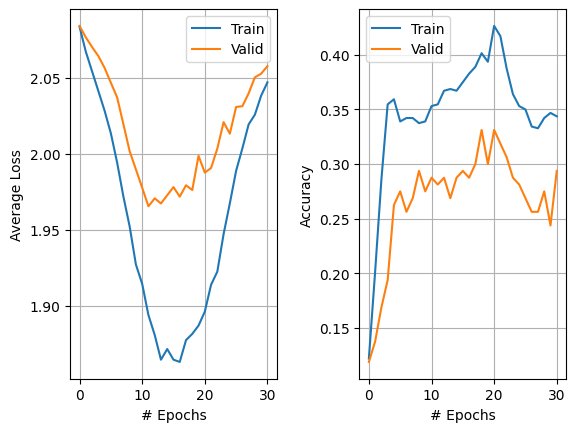

In [ ]:
###for training mode
cnn_high_decay = CNN(pretrained = True, dropout = False, dropout_p = 0.0)
trainAndPlotAndSave(cnn_high_decay,batch_size = 16, lr = 0.001, epoch =30, l2W = 0.001, file_name = "CNN_high_decay",download = False)
###for testing mode
weight = plot_sample("CNN_high_decay")
if not TRAIN:
  model = cnn_high_decay
  model.load_state_dict(weight)
  trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
  train(model, trainDL, validDL, lossfn, opt, epochs=1)


Lastly, we tried adding a dropout layer before the last fully connected layer, with varying dropout rates (p). We similarly tried two different dropout values: 0.3 and 0.8. We observe a similar trend with the L2 regularization: a low dropout probability minimally help the network to generalize.

Initial Model: train-loss=1.31 train-acc=0.99 valid-loss=1.87 valid-acc=0.37
Epoch    0: train-loss=1.31 train-acc=0.99 valid-loss=1.86 valid-acc=0.40


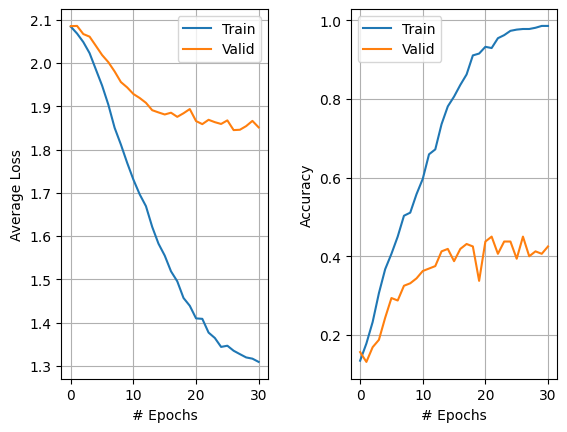

In [ ]:
###for training mode
cnn_low_dropout = CNN(pretrained = True, dropout = True, dropout_p = 0.3)
trainAndPlotAndSave(cnn_low_dropout,batch_size = 16, lr = 0.001, epoch =30, l2W = 0.001, file_name = "CNN_low_dropout",download = False)
###for testing mode
weight = plot_sample("CNN_low_dropout")
if not TRAIN:
  model = cnn_low_dropout
  model.load_state_dict(weight)
  trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
  train(model, trainDL, validDL, lossfn, opt, epochs=1)

However, a high dropout does not prevent the network from learning the task. We attribute this to that unlike L2 regularization, dropout regularization does not drive the gradient in an unfavored way, preseving the network's ability to learn.

In [ ]:
###for training mode
cnn_high_dropout = CNN(pretrained = True, dropout = True, dropout_p = 0.8)
trainAndPlotAndSave(cnn_high_dropout,batch_size = 16, lr = 0.001, epoch =30, l2W = 0.001, file_name = "CNN_high_dropout",download = False)
###for testing mode
weight = plot_sample("CNN_high_dropout",60)
if not TRAIN:
  model = cnn_high_dropout
  model.load_state_dict(weight)
  trainDL, validDL, lossfn, opt = createTrainingUtils(model,16,0.001)
  train(model, trainDL, validDL, lossfn, opt, epochs=1)